In [79]:
from datetime import datetime, timedelta, timezone
from IPython.display import clear_output
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pyautogui
import math
import time

pd.options.display.float_format = '{:,.2f}'.format

# Download data

### Fetching tickers from nasdaq and filtering out ETFs and stocks that we have a problem getting their prices

In [80]:
def get_all_tickers(etf=False):
    # Get a list of all available tickers from Yahoo Finance
    all_tickers = web.get_nasdaq_symbols()
    all_tickers = all_tickers[~all_tickers["Test Issue"]]  # Filter out stocks that we can't fetch their data for some reason

    if not etf:
        all_tickers = all_tickers[~all_tickers["ETF"]]  # Filter out ETFs
    tickers = all_tickers.index.tolist()
    return [str(ticker) for ticker in tickers if str(ticker).isalpha()]

In [81]:
def get_data(tickers_list, p="max"):
    return yf.download(tickers_list, period=p, interval="1d")

In [160]:
tickers = get_all_tickers()[:500]
# tickers = ["TSLA", "AAPL", "MSFT", "NVDA", "GOOG", "AACI"]
data = get_data(tickers)

[*********************100%%**********************]  500 of 500 completed


In [161]:
data_cop = data.copy()

In [162]:
new_df = pd.DataFrame(index=data_cop.index.year.unique(), columns=data_cop.columns)
new_df.drop("Adj Close", axis=1, level=0, inplace=True)
new_df["Volume"] = data_cop["Volume"].groupby(data_cop.index.year).mean()
new_df["Close"] = data_cop["Close"].groupby(data_cop.index.year).last()
new_df["Open"] = data_cop["Open"].groupby(data_cop.index.year).first()
new_df["High"] = data_cop["High"].groupby(data_cop.index.year).max()
new_df["Low"] = data_cop["Low"].groupby(data_cop.index.year).min()
for stock in new_df["Close"].columns:
    new_df["Change", stock] = np.nan
new_df["Change"] = new_df.xs("Close", axis=1, level=0).pct_change() * 100

C:\Users\sasso\AppData\Local\Temp\ipykernel_16984\1838130815.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Change", stock] = np.nan


In [163]:
stocks_checklist = pd.DataFrame(index=new_df["Close"].columns, columns=["Years up", "Div yield", "Sector", "avg daily vol", "Total Revenue Incr", "Gross Margin", "Gross Profit Incr", "Trading years", "Market cap", "EPS", "P/E"])

stocks_checklist

,Years up,Div yield,Sector,avg daily vol,Total Revenue Incr,Gross Margin,Gross Profit Incr,Trading years,Market cap,EPS,P/E
A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACIU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
AREBW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AREC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AREN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
stocks_checklist = pd.DataFrame(index=new_df["Close"].columns, columns=["Years up", "Div yield", "Sector", "avg daily vol", "Total Revenue Incr", "Gross Margin", "Gross Profit Incr", "Trading years", "Market cap", "EPS", "P/E"])

tickers = list(new_df["Close"].columns)  # In case some of the tickers failed, this is the ticker list straight from the returned df
# Years up in a row
tmp = new_df["Change"].copy().iloc[::-1]
tmp.fillna(-1, inplace=True)
neg_year = tmp.apply(lambda x: x[x < 0].index[0] if any(x<0) else None)
current_year = tmp.index[0]
stocks_checklist["Years up"] = current_year - neg_year.copy()
# stocks_checklist["Years up"] = 1
stocks_checklist["avg daily vol"] = new_df["Volume"].copy().iloc[-1:].mean()
stocks_checklist["avg daily vol"] = stocks_checklist["avg daily vol"].fillna(0)

# Eliminate by avg daily vol, so it'll be faster
stocks_checklist = stocks_checklist[stocks_checklist["avg daily vol"] > 400000]

# Div yield
print(f"0/{len(stocks_checklist.index)}")
i = 1
for ticker in stocks_checklist.index:
    clear_output(wait=True)
    print(ticker)
    print(f"{i}/{len(stocks_checklist.index)}")
    i += 1
    tmp = yf.Ticker(ticker)
    start_date = (datetime.now() - timedelta(days = 365))
    start_date = start_date.replace(tzinfo=timezone.utc)
    div_sum = tmp.dividends.loc[start_date:].sum()
    close_price = new_df["Close"][ticker].iloc[-1]
    div_yield = (div_sum/close_price) * 100
    stocks_checklist.loc[ticker, "Div yield"] = div_yield
    # Sector
    if "sector" in tmp.info:
        stocks_checklist.loc[ticker, "Sector"] = tmp.info["sector"]
    
    if "Gross Profit" in tmp.income_stmt.index:
        # Average Gross margin over the last 3 income statements
        if tmp.income_stmt.loc["Total Revenue"].all() > 0:
            stocks_checklist.loc[ticker, "Gross Margin"] = ((tmp.income_stmt.loc["Gross Profit"].iloc[::-1] / tmp.income_stmt.loc["Total Revenue"].iloc[::-1]) * 100).mean()  # Gross margin of the last 3 years
        
        # Gross profit increase percentage over the last 3 years (3 income statements)
        stocks_checklist.loc[ticker, "Gross Profit Incr"] = tmp.income_stmt.loc["Gross Profit"].iloc[::-1].pct_change().mean() * 100
    
    # Total Revenue increase percentage over the last 3 years (3 income statements)
    if "Total Revenue" in tmp.income_stmt.index:
        stocks_checklist.loc[ticker, "Total Revenue Incr"] = tmp.income_stmt.loc["Total Revenue"].iloc[::-1].pct_change().mean() * 100
    
    # Years since IPO
    if "firstTradeDateEpochUtc" in tmp.info:
        epoch = tmp.info["firstTradeDateEpochUtc"]
        if epoch > 0:
            fty = datetime.fromtimestamp(tmp.info["firstTradeDateEpochUtc"]).year  # First trade year
        else:
            fty = (datetime(1970, 1, 1) + timedelta(seconds=epoch)).year
        stocks_checklist.loc[ticker, "Trading years"] = current_year - fty

    # Market Cap
    if "marketCap" in tmp.info:
        stocks_checklist.loc[ticker, "Market cap"] = tmp.info["marketCap"]

    # P/E Compare stock's price to EPS (Earning per share)
    if "trailingEps" in tmp.info:
        eps = tmp.info["trailingEps"]
        stocks_checklist.loc[ticker, "EPS"] = eps
        if "Net Income" in tmp.incomestmt.index:
            net_income = tmp.incomestmt.loc["Net Income"][0]
            latest_close = tmp.info["currentPrice"]
            stocks_checklist.loc[ticker, "P/E"] = latest_close / eps

stocks_checklist["Div yield"].replace(0.0, np.nan, inplace=True)
stocks_checklist.replace([np.inf, -np.inf], np.nan, inplace=True)

ARES
192/192


In [167]:
# stocks_checklist["avg daily vol"].fillna(0, inplace=True)
stocks_checklist

,Years up,Div yield,Sector,avg daily vol,Total Revenue Incr,Gross Margin,Gross Profit Incr,Trading years,Market cap,EPS,P/E
A,0,0.69,Healthcare,"1,561,071.43",8.84,53.03,7.48,25.00,"38,837,682,176.00",4.19,31.63
AA,0,1.45,Basic Materials,"6,620,871.43",16.66,18.95,51.19,62.00,"4,929,396,736.00",-3.65,-7.57
AADI,0,NaN,Healthcare,"440,935.71",664.37,95.61,"1,288.10",6.00,"41,203,512.00",-2.32,-0.72
AAL,0,NaN,Industrials,"43,666,314.29",68.12,-7.71,"16,635.00",19.00,"8,901,228,544.00",2.39,5.70
AAOI,0,NaN,Technology,"2,905,150.00",-2.25,18.15,-18.11,11.00,"647,782,208.00",-2.10,-8.14
...,...,...,...,...,...,...,...,...,...,...,...
ARCO,0,1.55,Consumer Cyclical,"661,264.29",35.05,10.54,116.37,13.00,"2,580,523,776.00",0.86,14.24
ARDX,3,NaN,Healthcare,"8,833,828.57",224.97,93.43,225.30,10.00,"2,047,457,152.00",-0.06,-147.00
ARE,0,4.02,Real Estate,"922,921.43",17.29,70.71,15.56,27.00,"21,445,574,656.00",1.38,89.43
AREN,0,NaN,Communication Services,"405,271.43",32.27,33.63,113.40,16.00,"19,809,186.00",-2.92,-0.28


# Scoring

In [168]:
scores = pd.DataFrame(index=stocks_checklist.index, columns=[*stocks_checklist.columns, "Total"])  # Generate scoring dataframe

In [169]:
def total_scores(df):
    df.drop("Total", axis=1, inplace=True)
    df["Total"] = df.sum(axis=1)
    return df

### Dividend scoring

In [170]:
def div_func(x, peak1, peak2, med, sigma1, sigma2):
    f1 = (-1/(x*sigma1)) + peak2
    f2 = peak1 * np.exp(-((x-med)**2)/sigma2)
    return np.where(x < med, f2, f1)

In [171]:
peak1 = 6  # Y peak value of the first mishvaha
peak2 = 10  # Y peak value of the second mishvaha (the one where it shoef to)
starting_value = 0.4  # The score of a div yield 0

tmp = stocks_checklist["Div yield"].dropna()  # Drop no-dividend stocks
div_values = np.array(tmp.values)
div_stocks = np.array(tmp.index)
med = np.median(div_values)  # Median, to determine the peak of the first function
sigma1 = 1/(med*(peak2-peak1))  # In order for the second function to continue from where the first function stops (after the median point)
sigma2 = (med**2) / math.log(peak1/starting_value)  # Determine the slope by the starting point and peak of median
div_scores = div_func(div_values, peak1, peak2, med, sigma1, sigma2)

C:\Users\sasso\AppData\Local\Temp\ipykernel_16984\1739882789.py:2: RuntimeWarning: divide by zero encountered in divide
  f1 = (-1/(x*sigma1)) + peak2


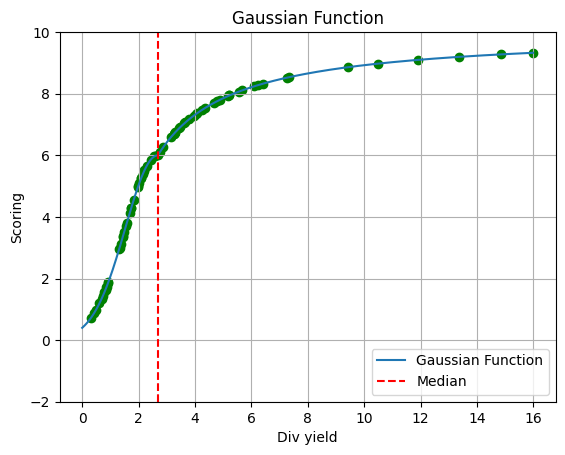

In [172]:
def plot_score(div_values, peak1, peak2, med, sigma1, sigma2):
    x_values = np.linspace(0, max(div_values), 5000)  # Generating 1000 values between 0 and 4
    y_values = div_func(x_values, peak1, peak2, med, sigma1, sigma2)
    # Calculate corresponding y values using the Gaussian function

    # Plot the function
    plt.plot(x_values, y_values, label=f'Gaussian Function')
    plt.ylim(-2, 10)  # Adjust these limits according to your needs

    plt.scatter(div_values, div_scores, color='green', marker='o')
    plt.axvline(med, color="red", linestyle="--", label="Median")
    plt.title('Gaussian Function')
    plt.xlabel('Div yield')
    plt.ylabel('Scoring')
    plt.legend()
    plt.grid(True)
plot_score(div_values, peak1, peak2, med, sigma1, sigma2)

In [173]:
scores.loc[div_stocks, "Div yield"] = div_scores

### Trading years score

In [174]:
def ty_func(values):
    # Linear
    max_years = max(values)
    f = values/(max_years/10)
    return f

In [175]:
ty_values = stocks_checklist["Trading years"]
ty_scores = ty_func(ty_values)
# ty_scores
scores["Trading years"] = ty_scores

### Years up scoring

In [176]:
def yu_func(values):  # years up func
    f = (-1/(0.1 * values) + 10)

    return np.where(values == 0, 0, np.where(values == 1, 2, f))

In [177]:
yu_values = stocks_checklist["Years up"]
yu_scores = yu_func(yu_values)
scores["Years up"] = yu_scores

### Average daily volume & Total rev incrs scoring & Gross profit incr

In [178]:
def linear_max_func(values):  # Score 10 (max) determined by max value in values
    m = 10/max(values)
    f = m*values
    return f

In [179]:
scores["avg daily vol"] = linear_max_func(stocks_checklist["avg daily vol"])

# Gross Profit Increase

In [180]:
def arctan_func(values, low, high, angle):
    high += 5
    w = 0 - math.tan(-(low*math.pi)/high - (math.pi/2))
    # f = 15*(np.arctan(values - w)/math.pi) + 2.5
    f = (high * (np.arctan(angle*values-w) + (math.pi/2)) / math.pi) + low

    return f

In [181]:
tmp = stocks_checklist["Gross Profit Incr"].dropna()
med = np.median(tmp)
low = -5
high = 10
sigma = 0.05
gross_scores = arctan_func(tmp, low, high, sigma)
scores["Gross Profit Incr"] = gross_scores


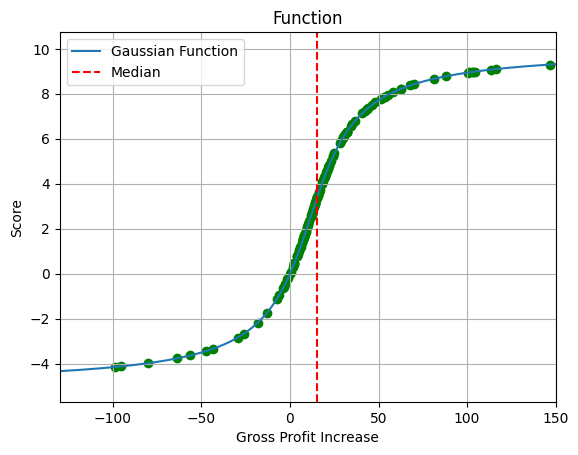

In [182]:
# Plot

x_values = np.linspace(-130, 150, 5000)  # Generating 1000 values between 0 and 4
gross_scores = arctan_func(tmp, low, high, sigma)
y_values = arctan_func(x_values, low, high, sigma)
# Calculate corresponding y values using the Gaussian function

# Plot the function
plt.plot(x_values, y_values, label=f'Gaussian Function')
# plt.ylim(-2, 10)  # Adjust these limits according to your needs
plt.xlim(-130, 150)
plt.scatter(tmp, gross_scores, color='green', marker='o')
plt.axvline(med, color="red", linestyle="--", label="Median")
plt.title('Function')
plt.xlabel('Gross Profit Increase')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
# plot_score(div_values, peak1, peak2, med, sigma1, sigma2)

# Total Rev Increase

In [183]:
tmp = stocks_checklist["Total Revenue Incr"].dropna()
med = np.median(tmp)
low = -5
high = 10
sigma = 0.05
rev_incr_scores = arctan_func(tmp, low, high, sigma)
scores["Total Revenue Incr"] = rev_incr_scores

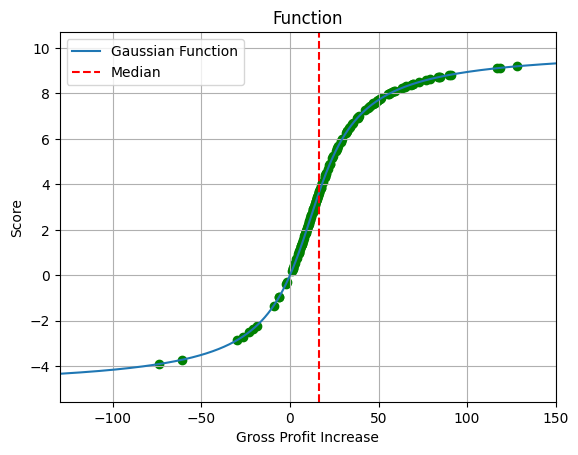

In [184]:
# Plot

x_values = np.linspace(-130, 150, 5000)  # Generating 1000 values between 0 and 4
y_values = arctan_func(x_values, low, high, sigma)
rev_incr_scores = arctan_func(tmp, low, high, sigma)
# Calculate corresponding y values using the Gaussian function

# Plot the function
plt.plot(x_values, y_values, label=f'Gaussian Function')
# plt.ylim(-2, 10)  # Adjust these limits according to your needs
plt.xlim(-130, 150)
plt.scatter(tmp, rev_incr_scores, color='green', marker='o')
plt.axvline(med, color="red", linestyle="--", label="Median")
plt.title('Function')
plt.xlabel('Gross Profit Increase')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
# plot_score(div_values, peak1, peak2, med, sigma1, sigma2)

# Gross Margin Score

In [185]:
tmp = stocks_checklist["Gross Margin"].dropna()
med = np.median(tmp)
low = -5
high = 10
sigma = 0.02
gross_margin_scores = arctan_func(tmp, low, high, sigma)
scores["Gross Margin"] = gross_margin_scores

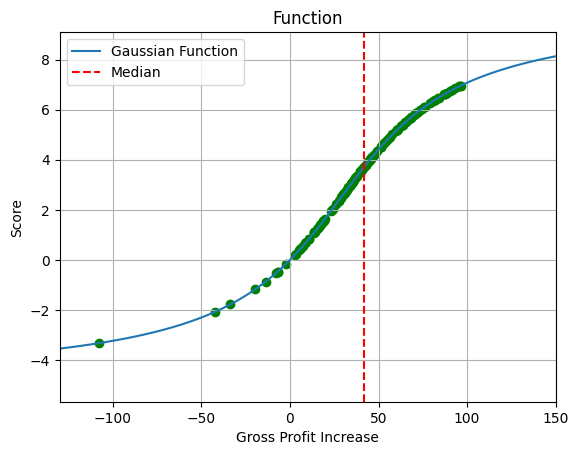

In [186]:
# Plot

x_values = np.linspace(-130, 150, 5000)  # Generating 1000 values between 0 and 4
y_values = arctan_func(x_values, low, high, sigma)

# Plot the function
plt.plot(x_values, y_values, label=f'Gaussian Function')
# plt.ylim(-2, 10)  # Adjust these limits according to your needs
plt.xlim(-130, 150)
plt.scatter(tmp, gross_margin_scores, color='green', marker='o')
plt.axvline(med, color="red", linestyle="--", label="Median")
plt.title('Function')
plt.xlabel('Gross Profit Increase')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
# plot_score(div_values, peak1, peak2, med, sigma1, sigma2)

# Get Market cap score

In [187]:
def linear_mean_func(values, med_score, med):
    # m = med_score/np.median(values)
    # sigma2 = 0.001
    m1 = med_score/med
    f1 = m1*values
    # x1 = 8/m1  # The x value when y=8 in the first function
    # f2 = -(1/(values-x1)*sigma2) + 10
    # print(x1)
    # print(m1)
    # return np.where(f1 <= 8, f1, f2)
    return np.where(f1 <= 10, f1, 10)

In [188]:
market_cap_vals = stocks_checklist["Market cap"]
market_cap_scores = linear_mean_func(market_cap_vals, 5, market_cap_vals.mean())
scores["Market cap"] = market_cap_scores

In [189]:
def plot(values, func, params=None):
    # plot_x = np.linspace(-130, 150, 5000)  # Generating 1000 values between 0 and 4
    values = values.dropna()
    plot_x = np.linspace(min(values), max(values), 5000)  # Generating 1000 values between 0 and 4
    if params:
        plot_scores = func(values, *params)
        plot_y = func(plot_x, *params)
    else:
        plot_scores = func(values)
        plot_y = func(plot_x)
    med = np.median(values)  # Median, to determine the peak of the first function
    # print(med)
    # Plot the function
    plt.plot(plot_x, plot_y, label=f'Gaussian Function')
    # plt.ylim(0, 2)  # Adjust these limits according to your needs
    # plt.xlim(-10, 100000000000)
    plt.scatter(values, plot_scores, color='green', marker='o')
    plt.axvline(med, color="red", linestyle="--", label="Median")
    plt.axvline(values.mean(), color="green", linestyle="--", label="Median")
    plt.title('Function')
    plt.xlabel('Values')
    plt.ylabel('Scores')
    plt.legend()
    plt.grid(True)

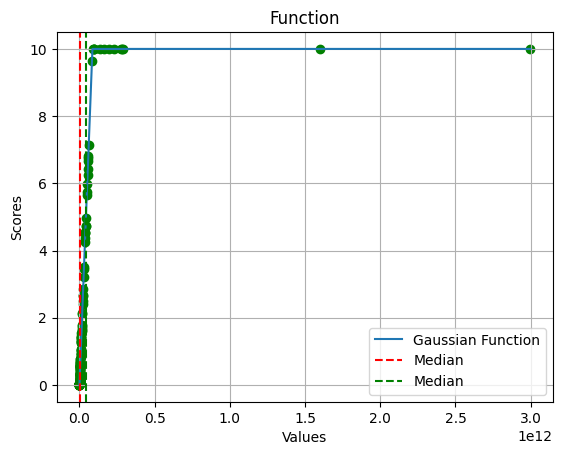

In [190]:
plot(stocks_checklist["Market cap"], linear_mean_func, [5, stocks_checklist["Market cap"].mean()])

# EPS Scoring

In [191]:
def linear_2points(values, pt1, pt2):
    # pt - tuple (x, y)
    slope = (pt1[1] - pt2[1])/(pt1[0] - pt2[0])
    f = slope*values
    return f

In [192]:
def linear_2points_zero(values, min_score, max_score):
    f1 = linear_2points(values, (0, 0), (min(values), min_score))
    f2 = linear_2points(values, (0, 0), (max(values), max_score))
    return np.where(values < 0, f1, f2)

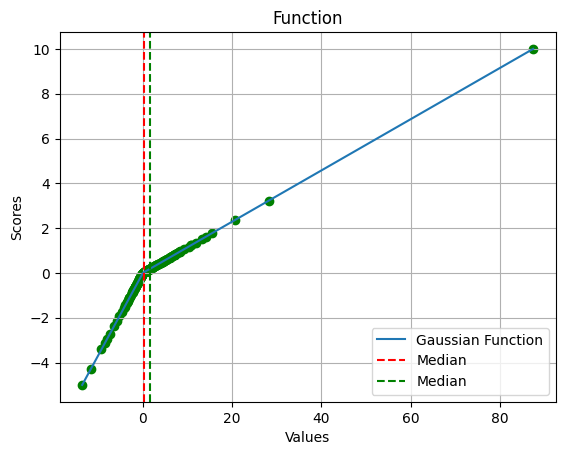

In [193]:
plot(stocks_checklist["EPS"], linear_2points_zero, [-5, 10])

In [194]:
scores["EPS"] = linear_2points_zero(stocks_checklist["EPS"], -5, 10)
scores["P/E"] = linear_2points_zero(stocks_checklist["P/E"], -5, 10)

In [195]:
total_scores(scores)

,Years up,Div yield,Sector,avg daily vol,Total Revenue Incr,Gross Margin,Gross Profit Incr,Trading years,Market cap,EPS,P/E,Total
A,0.00,1.34,NaN,0.19,1.86,4.65,1.54,4.03,4.52,0.48,0.22,18.82
AA,0.00,3.38,NaN,0.79,3.70,1.56,7.77,10.00,0.57,-1.34,-0.09,26.34
AADI,0.00,NaN,NaN,0.05,9.85,6.93,9.93,0.97,0.00,-0.85,-0.01,26.87
AAL,0.00,NaN,NaN,5.21,8.38,-0.52,9.99,3.06,1.04,0.27,0.04,27.48
AAOI,0.00,NaN,NaN,0.35,-0.38,1.49,-2.17,1.77,0.08,-0.77,-0.10,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...
ARCO,0.00,3.71,NaN,0.08,6.63,0.82,9.10,2.10,0.30,0.10,0.10,22.93
ARDX,6.67,NaN,NaN,1.05,9.55,6.85,9.55,1.61,0.24,-0.02,-1.72,33.79
ARE,0.00,7.33,NaN,0.11,3.83,5.83,3.45,4.35,2.50,0.16,0.61,28.17
AREN,0.00,NaN,NaN,0.05,6.33,2.95,9.07,2.58,0.00,-1.08,-0.00,19.92


In [196]:
stocks_checklist

,Years up,Div yield,Sector,avg daily vol,Total Revenue Incr,Gross Margin,Gross Profit Incr,Trading years,Market cap,EPS,P/E
A,0,0.69,Healthcare,"1,561,071.43",8.84,53.03,7.48,25.00,"38,837,682,176.00",4.19,31.63
AA,0,1.45,Basic Materials,"6,620,871.43",16.66,18.95,51.19,62.00,"4,929,396,736.00",-3.65,-7.57
AADI,0,NaN,Healthcare,"440,935.71",664.37,95.61,"1,288.10",6.00,"41,203,512.00",-2.32,-0.72
AAL,0,NaN,Industrials,"43,666,314.29",68.12,-7.71,"16,635.00",19.00,"8,901,228,544.00",2.39,5.70
AAOI,0,NaN,Technology,"2,905,150.00",-2.25,18.15,-18.11,11.00,"647,782,208.00",-2.10,-8.14
...,...,...,...,...,...,...,...,...,...,...,...
ARCO,0,1.55,Consumer Cyclical,"661,264.29",35.05,10.54,116.37,13.00,"2,580,523,776.00",0.86,14.24
ARDX,3,NaN,Healthcare,"8,833,828.57",224.97,93.43,225.30,10.00,"2,047,457,152.00",-0.06,-147.00
ARE,0,4.02,Real Estate,"922,921.43",17.29,70.71,15.56,27.00,"21,445,574,656.00",1.38,89.43
AREN,0,NaN,Communication Services,"405,271.43",32.27,33.63,113.40,16.00,"19,809,186.00",-2.92,-0.28


In [197]:
total_columns = 11
nan_columns = scores.isna().sum(axis=1)

A       1
AA      1
AADI    2
AAL     2
AAOI    2
       ..
ARCO    1
ARDX    2
ARE     1
AREN    2
ARES    1
Length: 192, dtype: int64